In [83]:

import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot


### 2. Загрузка данных

Данные обучения, которые включают в себя unit_sales с датой, store_nbr и item_nbr, а также уникальный идентификатор для маркировки строк.
Единицы unit_sales могут быть целыми (например, мешок чипсов) или плавающими (например, 1,5 кг сыра).

Отрицательные значения unit_sales представляют собой возврат этого конкретного элемента.

В столбце onpromotion указано, участвовал ли этот item_nbr в продвижении на указанную дату.

In [ ]:
train = pd.read_csv('data/train.zip', index_col='id')
train.head()

Данные о магазине, включая город, штат, тип и кластер.

In [ ]:
stores = pd.read_csv('data/stores.zip')
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Данные по продукту, включая категорию, класс и указание о том, скоропортящийся ли продукт.

Товары, отмеченные как скоропортящиеся, имеют вес 1.25 балла; в противном случае вес равен 1.0.

In [ ]:
items = pd.read_csv('data/items.zip')
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


Праздники и события

In [ ]:
holiday_events = pd.read_csv('data/holidays_events.zip')
holiday_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


Транзакции покупок

In [ ]:
transactions = pd.read_csv('data/transactions.zip')
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


### 5. Характеристики и параметры временных рядов. Практика

Задание будем выполнять для магазина с номером 25. Для этого сгруппируйте данные по дате и суммируйте количество всех продаж.

In [ ]:
df = train[train['store_nbr']==25].groupby('date').sum().reset_index().drop(['store_nbr', 'item_nbr', 'onpromotion'], axis = 1)
df.head()

,date,unit_sales
0,2013-01-01,2511.619
1,2013-01-02,5316.224
2,2013-01-03,4442.913
3,2013-01-04,4844.354
4,2013-01-05,5817.526


Сделайте сезонную декомпозицию.

In [ ]:
df = df.set_index(pd.DatetimeIndex(df['date']))
df.drop(['date'], axis = 1, inplace = True)
df.head()

,unit_sales
date,
2013-01-01,2511.619
2013-01-02,5316.224
2013-01-03,4442.913
2013-01-04,4844.354
2013-01-05,5817.526


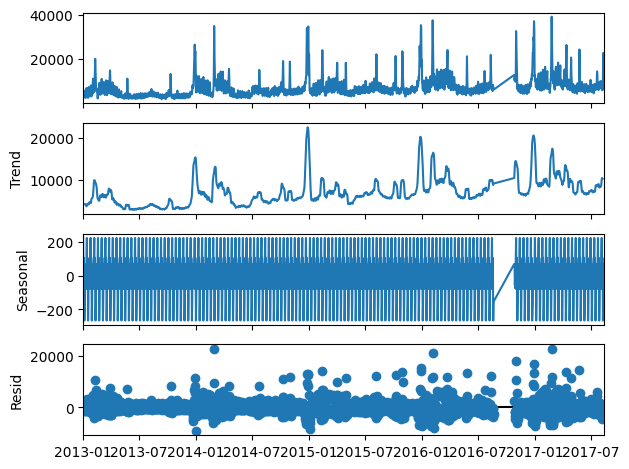

In [ ]:
decomposition = seasonal_decompose(df, model='additive', period=1) 
decomposition.plot()
pyplot.show() # любуемся результатом

В Jupyter Notebook ответьте на вопросы:

1. Сколько элементов содержит исходный датасет?

2. Сколько элементов содержит шумовая часть?

3. Сколько числовых элементов содержит шумовая часть?

4. Сколько элементов содержит сезонная часть?

5. Сколько числовых элементов содержит трендовая часть?

In [ ]:
trend_part = decomposition.trend # отдельно трендовая составляющаяя
seasonal_part = decomposition.seasonal # отдельно сезонная составляющаяя
residual_part = decomposition.resid # отдельно шум: то, что осталось

print(f'Элементов в исходном датасете: {len(df.index)}')
print(f'Элементов в шумовой части: {len(residual_part)}')
print(f'Ненулевых элементов в шумовой части: {len(residual_part[residual_part != 0])}')
print(f'Элементов в сезонной части: {len(seasonal_part)}')
print(f'Ненулевых элементов в сезонной части: {len(seasonal_part[seasonal_part != 0])}')
print(f'Элементов в трендовой части: {len(trend_part)}')
print(f'Ненулевых элементов в трендовой части: {len(trend_part[trend_part != 0])}')

Элементов в исходном датасете: 1618
Элементов в шумовой части: 1618
Ненулевых элементов в шумовой части: 1618
Элементов в сезонной части: 1618
Ненулевых элементов в сезонной части: 1618
Элементов в трендовой части: 1618
Ненулевых элементов в трендовой части: 1618


Выполните тест Дики-Фуллера.

In [ ]:
test = adfuller(df['unit_sales'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда 
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -4.8589926653181825
p-value:  4.1883941929077364e-05
Critical values:  {'1%': -3.4344642432857992, '5%': -2.8633571955690647, '10%': -2.5677374399794197}
ряд стационарен
